In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
#import pyvista as pv
from skimage.filters import gaussian
from scipy.ndimage import gaussian_filter, binary_closing, binary_fill_holes, generate_binary_structure
#from scipy.ndimage import zoom, center_of_mass, shift, affine_transform
#from scipy import ndimage as ndi
#from scipy.spatial import procrustes
#from scipy.spatial.transform import Rotation as R
#import cv2
import SimpleITK as sitk
#import ipywidgets
from pathlib import Path
from tqdm import tqdm
#from collections import Counter
#import warnings
#warnings.filterwarnings("ignore")
#"ipyvtklink", "panel", "ipygany", "static", "pythreejs", "client", "server", "trame", "none"
#pv.set_jupyter_backend("panel")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
PIPELINE_ROOT = Path('./').absolute().parents[1]
PIPELINE_ROOT = PIPELINE_ROOT.as_posix()
sys.path.append(PIPELINE_ROOT)
print(PIPELINE_ROOT)

data_path = '/net/birdstore/Active_Atlas_Data/data_root/atlas_data'
from library.atlas.atlas_utilities import register_volume, adjust_volume, \
    affine_transform_point, resample_image, load_transformation, get_min_max_mean, \
    numpy_to_sitk, create_average_binary_mask, resample_image

from library.controller.sql_controller import SqlController


/home/eddyod/programming/pipeline/src


In [4]:
def visualize_slices(volume, title="Slice View"):
    """Visualize the middle slices of a 3D volume."""
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    mid_slices = [s // 2 for s in volume.shape]
    
    axes[0].imshow(volume[mid_slices[0], :, :], cmap='gray')
    axes[0].set_title("Axial Slice")
    axes[1].imshow(volume[:, mid_slices[1], :], cmap='gray')
    axes[1].set_title("Coronal Slice")
    axes[2].imshow(volume[:, :, mid_slices[2]], cmap='gray')
    axes[2].set_title("Sagittal Slice")
    
    for ax in axes:
        ax.axis("on")
    plt.suptitle(title)
    plt.show()
    
def mean_consensus_mask(arrays, threshold=0.5, smooth_sigma=1.5, closing_iterations=2):
    """
    Combine multiple registered 3D binary arrays into a smooth, hole-free consensus mask.
    
    Parameters
    ----------
    arrays : list or np.ndarray
        List of 3D binary numpy arrays (same shape, aligned).
    threshold : float
        Threshold on the mean probability map to obtain binary mask (0–1).
    smooth_sigma : float
        Sigma for Gaussian smoothing to smooth edges.
    closing_iterations : int
        Number of morphological closing iterations to fill small gaps.
    
    Returns
    -------
    np.ndarray
        A smooth, hole-free 3D binary numpy array.
    """
    images = [sitk.GetImageFromArray(img.astype(np.float32)) for img in arrays]
    reference_image_index, reference_image = max(enumerate(images), key=lambda img: np.prod(img[1].GetSize()))
    # Resample all images to the reference
    resampled_images = [resample_image(img, reference_image) for img in images]
    arrays = [sitk.GetArrayFromImage(a) for a in resampled_images]
    
    # Stack and compute voxelwise mean
    arrays = np.stack(arrays, axis=0)
    mean_map = arrays.mean(axis=0)

    # Smooth the mean map
    smoothed = gaussian_filter(mean_map, sigma=smooth_sigma)

    # Threshold to binary
    upper = np.quantile(smoothed, 0.75)
    print(upper)
    binary = smoothed > upper

    # Morphological closing to remove small holes or gaps
    struct = generate_binary_structure(3, 2)  # 3D connectivity
    closed = binary_closing(binary, structure=struct, iterations=closing_iterations)

    # Fill any remaining internal holes slice-wise and in 3D
    filled = binary_fill_holes(closed)

    return filled.astype(np.uint8)

In [10]:
volumes = []
brains = ['MD585', 'MD589', 'MD594']
#brains = ['AtlasV8']
for brain in brains:
    structure_dir = os.path.join(data_path, brain, 'structure')
    structures = sorted(os.listdir(structure_dir))
    structures = ['IC.npy']
    for structure in structures:
        structure_path = os.path.join(structure_dir, structure)
        arr = np.load(structure_path)
        volumes.append(arr)
        ids = np.unique(arr)
        print(f'{brain} {arr.dtype} {len(ids)} {structure_path}')

MD585 uint8 2 /net/birdstore/Active_Atlas_Data/data_root/atlas_data/MD585/structure/IC.npy
MD589 uint8 2 /net/birdstore/Active_Atlas_Data/data_root/atlas_data/MD589/structure/IC.npy
MD594 uint8 2 /net/birdstore/Active_Atlas_Data/data_root/atlas_data/MD594/structure/IC.npy


(192, 207, 372) float32


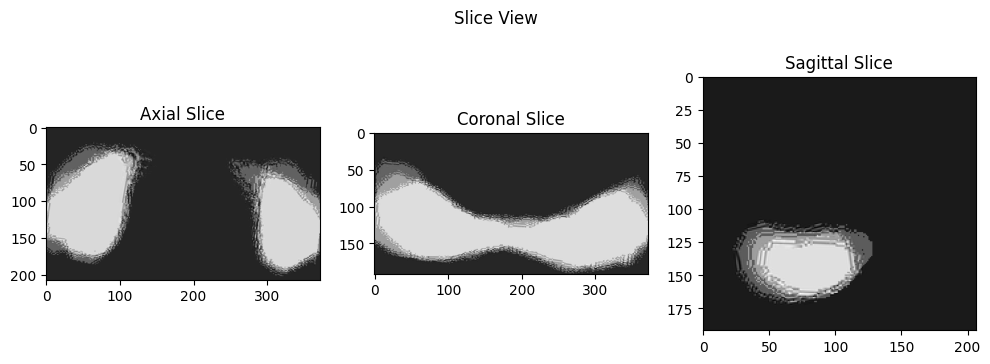

In [11]:
avg_volume = create_average_binary_mask(volumes)
print(avg_volume.shape, avg_volume.dtype)
visualize_slices(avg_volume)

[  0. 255.]
[11597378  3187390]
float32


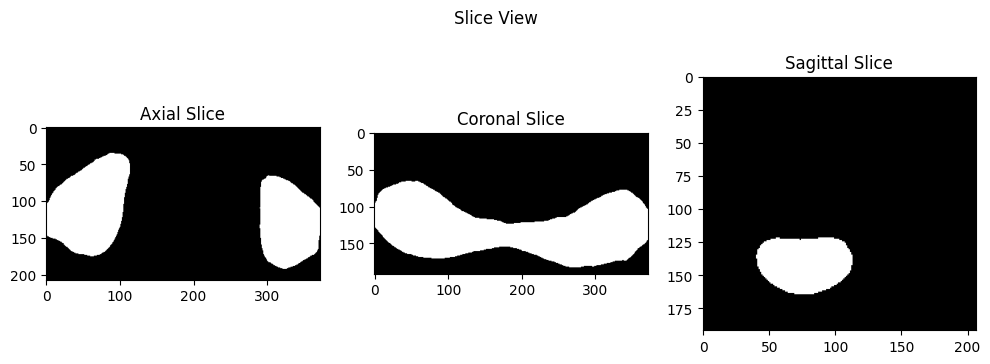

In [14]:
#testarr = adjust_volume(avg_volume, allen_id=255)
allen_id = 255
volume = avg_volume.copy()
volume = gaussian(volume, 2.0) 
upper = 175
volume[(volume > upper) ] = 255
volume[(volume != 255)] = 0
ids, counts = np.unique(volume, return_counts=True)
print(ids)
print(counts)
print(volume.dtype)
visualize_slices(volume)

In [ ]:
plt.hist(volume.astype(np.uint8).ravel(), bins=20, edgecolor='black')
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Histogram of Data")
plt.show()

In [ ]:
unique_values, counts = np.unique(volume.astype(np.uint8), return_counts=True)
# 2. Get the indices that would sort the counts
sorted_indices = np.argsort(counts)
print(f"Sorted indices (ascending by count): {sorted_indices}")

# 3. Get the indices for the two highest counts (last two elements)
highest_count_indices = sorted_indices[-2:]

# 4. Get the final two unique values with the highest counts
two_highest = unique_values[highest_count_indices]
print(f"\nThe two highest unique IDs are: {two_highest}")

# To check the counts of the highest IDs
highest_counts = counts[highest_count_indices]
print(f"Their respective counts are: {highest_counts}")